# Home Credit Default Risk - Kaggle competition

This notebook will cover basic feature engineering and construction of a base model.

## Initial Setup
#### Import packages

In [190]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

#### Load datasets from EDA notebook

In [191]:
%store -r app_train
%store -r app_test
%store -r bureau_tgt
%store -r prev_app_tgt

print('Training set shape: ',app_train.shape)
print('Test set shape: ',app_test.shape)
print('Bureau data shape: ',bureau_tgt.shape)
print('Prev applications data shape: ',prev_app_tgt.shape)

Training set shape:  (307511, 245)
Test set shape:  (48744, 243)
Bureau data shape:  (1716428, 38)
Prev applications data shape:  (1670214, 164)


## Handle Missing Values

In [200]:
# Identify columns with missing values in training set
def missing_vals_cols(df):
    mv_cols = df.columns[df.isnull().any()].tolist()
    print('Dataframe has {} columns.\nThere are {} columns with missing values.'.format(df.shape[1],len(mv_cols)))
    
    return mv_cols

In [197]:
mv_cols = missing_vals_cols(app_train)

Dataframe has 245 columns.
There are 61 columns with missing values.



In [198]:
# AMT_GOODS_PRICE

# It would seem reasonalbe to set AMT_GOODS_PRICE equal to AMT_CREDIT
# Let's check how well these columns align for the non-null cases
temp = app_train[app_train.AMT_GOODS_PRICE.notnull()]
sum(temp.AMT_CREDIT - temp.AMT_GOODS_PRICE)/sum(temp.AMT_CREDIT)

0.10164667949810266

In [199]:
# AMT_GOODS_PRICE is on average 10% lower than the AMT_CREDIT
# So impute missing AMT_GOODS_PRICE values as 0.9*AMT_CREDIT
app_train.loc[app_train.AMT_GOODS_PRICE.isnull(),'AMT_GOODS_PRICE'] = 0.9*app_train.AMT_CREDIT

# Check whether it worked
mv_cols = missing_vals_cols(app_train)

Dataframe has 245 columns.
There are 61 columns with missing values.



In [201]:
# AMT_REQ_CREDIT variables

# Setting NaNs to zero or the mean number of requests would seem to be sensible approaches.
# Check mean number of requests:
print('Mean daily requests:',np.mean(app_train.AMT_REQ_CREDIT_BUREAU_DAY))
print('Mean quarterly requests:',np.mean(app_train.AMT_REQ_CREDIT_BUREAU_QRT))      

Mean daily requests: 0.0070002105326475985
Mean quarterly requests: 0.26547414959848414


In [202]:
# Mean requests are very low anyway, so we will set missing values for these variables to zero.
for col in ['AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 
            'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR']:
    app_train.loc[app_train[col].isnull(),col] = 0

# Check whether it worked
mv_cols = missing_vals_cols(app_train)

Dataframe has 245 columns.
There are 55 columns with missing values.


In [207]:
# Information on the building where the client lives

# Approach: impute using the same strategy as the variable
housing_vars = ['APARTMENTS', 'BASEMENTAREA','COMMONAREA','ELEVATORS','ENTRANCES','FLOORSMAX','FLOORSMIN',
                'LANDAREA','LIVINGAPARTMENTS','LIVINGAREA','NONLIVINGAPARTMENTS','NONLIVINGAREA',
                'YEARS_BEGINEXPLUATATION','YEARS_BUILD']

for col in housing_vars:
    app_train.loc[app_train[col+'_AVG'].isnull(),col+'_AVG'] = np.nanmean(app_train[col+'_AVG'])
    app_train.loc[app_train[col+'_MEDI'].isnull(),col+'_MEDI'] = np.nanmedian(app_train[col+'_MEDI'])
    app_train.loc[app_train[col+'_MODE'].isnull(),col+'_MODE'] = stats.mode(app_train[col+'_MODE'],nan_policy='omit')

# TOTALAREA_MODE does not have corresponding AVG and MEDI vars, so process this separately.
app_train.loc[app_train['TOTALAREA_MODE'].isnull(),'TOTALAREA_MODE'] = stats.mode(app_train['TOTALAREA_MODE'],nan_policy='omit')

# Check whether it worked
mv_cols = missing_vals_cols(app_train)
print('\nColumns with missing values:')
mv_cols

Dataframe has 245 columns.
There are 0 columns with missing values.

Columns with missing values:


[]

In [206]:
# For the remaining variables, we will take the median.
for col in mv_cols:
    app_train.loc[app_train[col].isnull(),col] = np.nanmedian(app_train[col])
    
missing_vals_cols(app_train)

Dataframe has 245 columns.
There are 0 columns with missing values.


[]

## Feature Engineering

### Additional features from training set

Ideas:
- Amount of credit relative to income (AMT_CREDIT/AMT_INCOME_TOTAL)
- Amount of annuity relative to income (AMT_ANNUITY/AMT_INCOME_TOTAL)
- Amount of credit relative to age (AMT_CREDIT/DAYS_BIRTH)
- Length of current employment relative to age (DAYS_EMPLOYED/DAYS_BIRTH)

In [208]:
# Start by appending test set to train set so that features are consistent
app_train['test_set'] = 0
app_test['test_set'] = 1

app_train_test = app_train.append(app_test)

print('Train set shape:', app_train.shape)
print('Test set shape:', app_test.shape)
print('Combined set shape:', app_train_test.shape)

Train set shape: (307511, 245)
Test set shape: (48744, 243)
Combined set shape: (356255, 245)


In [209]:
# Create new features from existing
app_train_test['CREDIT_INCOME'] = app_train_test['AMT_CREDIT']/app_train_test['AMT_INCOME_TOTAL']
app_train_test['ANNUITY_INCOME'] = app_train_test['AMT_ANNUITY']/app_train_test['AMT_INCOME_TOTAL']
app_train_test['CREDIT_AGE'] = app_train_test['AMT_CREDIT']/app_train_test['DAYS_BIRTH']
app_train_test['EMPT_AGE'] = app_train_test['DAYS_EMPLOYED']/app_train_test['DAYS_BIRTH']

print('Combined set shape:', app_train_test.shape)

Combined set shape: (356255, 249)


                CREDIT_INCOME  ANNUITY_INCOME  CREDIT_AGE  EMPT_AGE    TARGET
CREDIT_INCOME        1.000000        0.780012   -0.560861  0.026530 -0.007727
ANNUITY_INCOME       0.780012        1.000000   -0.325919 -0.015527  0.014268
CREDIT_AGE          -0.560861       -0.325919    1.000000 -0.102270  0.002729
EMPT_AGE             0.026530       -0.015527   -0.102270  1.000000 -0.049603
TARGET              -0.007727        0.014268    0.002729 -0.049603  1.000000


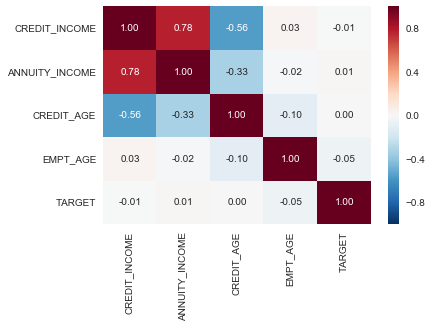

In [211]:
# Check whether these new features are likely to be of interest 
# by computing their correlation with the target variable.
correlations = app_train_test[['CREDIT_INCOME','ANNUITY_INCOME','CREDIT_AGE','EMPT_AGE','TARGET']].corr()
print(correlations)

# Correlation heatmap
sns.heatmap(correlations, annot=True, fmt = ".2f");

It appears as though EMPT_AGE is the only variable that has some relationship with the target variable. 

In [212]:
# Re-separate training and test sets before modelling.
app_train = app_train_test.loc[(app_train_test['test_set']==0),].drop(['test_set'], axis=1)
app_test = app_train_test.loc[(app_train_test['test_set']==1),].drop(['test_set','TARGET'], axis=1)

print('Train set shape:', app_train.shape)
print('Test set shape:', app_test.shape)

Train set shape: (307511, 248)
Test set shape: (48744, 247)



## Baseline Models
### Training data

#### Logistic regression

Start with basic logistic regression using only features from the training dataset in order to get a baseline.

According to the Kaggle information, the evaluation variable is ROC AUC score.

In [237]:
# Import modelling libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [221]:
# Set up features, target, test and train datasets

X = app_train.drop(['TARGET'], axis=1)
X_orig = app_train.drop(['CREDIT_INCOME','ANNUITY_INCOME','CREDIT_AGE','EMPT_AGE','TARGET'], axis=1) # without engineered features
y = app_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [226]:
# Set up pipeline for logistic regression

logreg = LogisticRegression()

steps_log = [('scaler', StandardScaler()),
             ('logistic_regression', logreg)]

pipeline_log = Pipeline(steps_log)

pipeline_log.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [230]:
# Make predictions on test dataset
y_pred_log = pipeline_log.predict(X_test)

# Predicted probabilities
y_pred_prob_log = pipeline_log.predict_proba(X_test)[:, 1]

print('Predicted classifications:',y_pred_log[:10])
print('Predicted probabilities:',y_pred_prob_log[:10])

Predicted values: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Predicted probabilities: [0.237 0.025 0.155 0.015 0.085 0.203 0.045 0.167 0.101 0.052]


In [232]:
# Metrics (competition will be evaluated on ROC AUC score)

# ROC AUC score
print('ROC AUC score:',roc_auc_score(y_test, y_pred_prob_log))

# Accuracy score
print('\nAccuracy score: ',accuracy_score(y_pred_log, y_test))

# Confusion matrix
print('\nConfusion matrix:\n',confusion_matrix(y_test, y_pred_log))

# Classification report
print('\nClassification report:\n',classification_report(y_test, y_pred_log))

ROC AUC score: 0.747997734761

Accuracy score:  0.919402305579

Confusion matrix:
 [[56481    73]
 [ 4884    65]]

Classification report:
              precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     56554
        1.0       0.47      0.01      0.03      4949

avg / total       0.88      0.92      0.88     61503



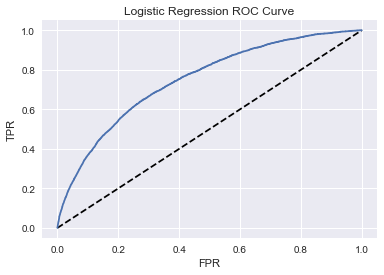

In [233]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_log)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [238]:
X_scaled = scale(X)
cv_scores_log = cross_val_score(logreg, X_scaled, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:',cv_scores_log)
print('Mean score:', np.mean(cv_scores_log))

ROC AUC scores from cross-validation: [0.747 0.746 0.742 0.748 0.751]
Mean score:  0.746865469651


In [247]:
# Check whether model performs better with or without the added features
X_orig_scaled = scale(X_orig)
cv_scores_log = cross_val_score(logreg, X_orig_scaled, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:',cv_scores_log)
print('Mean score:', np.mean(cv_scores_log))

ROC AUC scores from cross-validation: [0.745 0.745 0.742 0.748 0.751]
Mean score:  0.746287678528


The additional features make next to no difference to the model performance. 

#### Random Forest model

In [248]:
# Random forest estimator using 100 trees
random_forest = RandomForestClassifier(n_estimators = 100, random_state=42,verbose=1)

steps_rf = [('scaler', StandardScaler()),
            ('random_forest',random_forest)]

pipeline_rf = Pipeline(steps_rf)

pipeline_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.2min finished


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=1, warm_start=False))])

In [249]:
# Make predictions on test dataset
y_pred_rf = pipeline_rf.predict(X_test)

# Predicted probabilities
y_pred_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print('Predicted classifications:',y_pred_rf[:10])
print('Predicted probabilities:',y_pred_prob_rf[:10])

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished


Predicted classifications: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Predicted probabilities: [0.230 0.050 0.090 0.020 0.050 0.090 0.040 0.200 0.080 0.050]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


In [250]:
# Metrics (competition will be evaluated on ROC AUC score)

# ROC AUC score
print('ROC AUC score:',roc_auc_score(y_test, y_pred_prob_rf))

# Accuracy score
print('\nAccuracy score: ',accuracy_score(y_pred_rf, y_test))

# Confusion matrix
print('\nConfusion matrix:\n',confusion_matrix(y_test, y_pred_rf))

# Classification report
print('\nClassification report:\n',classification_report(y_test, y_pred_rf))

ROC AUC score: 0.711351090027

Accuracy score:  0.919564899273

Confusion matrix:
 [[56553     1]
 [ 4946     3]]

Classification report:
              precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     56554
        1.0       0.75      0.00      0.00      4949

avg / total       0.91      0.92      0.88     61503



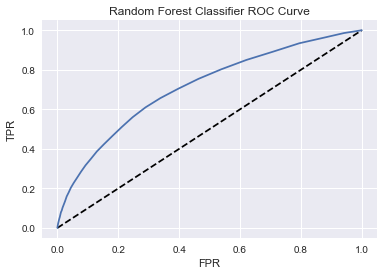

In [251]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Random Forest Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest Classifier ROC Curve')
plt.show()

In [252]:
cv_scores_rf = cross_val_score(random_forest, X_scaled, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:', cv_scores_rf)
print('Mean score:', np.mean(cv_scores_rf))

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


ROC AUC scores from cross-validation: [0.712 0.711 0.705 0.713 0.707]
Mean score:  0.709643772233


## Feature Engineering

### Credit Bureau dataset
Ideas:
- Flag for whether applicant has had a previous Bureau loan (SK_ID_CURR is in Bureau = True)
- Count of the number of previous Bureau loans (count of SK_ID_CURR in Bureau)
- Flag for whether the applicant had an overdue/defaulted Bureau loan (
- Max length of previous loan
- Max size of previous loan
- Flag for whether applicant has a current Bureau loan
- Max 

In [29]:
list(bureau_tgt)

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY',
 'TARGET',
 'CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Cash loan (non-earmarked)',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Interbank credit',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
 'CREDIT_TYPE_Loan for the purchase of equipment',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mobile operato

### Previous Applications dataset

#### Save data for transerral to other notebooks

In [ ]:
%store app_train
%store app_test
%store bureau_tgt
%store prev_app_tgt